In [6]:
import torch
import pandas as pd
from tqdm.notebook import tqdm

In [13]:
data_frame = pd.read_csv('sentiment_dataset.csv', names=['identifier', 'text', 'emotions'])
data_frame.set_index('identifier', inplace=True)
data_frame.head()

,text,emotions
identifier,,
611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merc...,nocode
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
614877582664835073,@Sofabsports thank you for following me back. ...,happy
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy


In [15]:
emotions_counts = data_frame.emotions.value_counts()

In [16]:
data_frame = data_frame[~data_frame.emotions.str.contains('\|')]
data_frame = data_frame[data_frame.emotions != 'nocode']
data_frame.emotions.value_counts()

happy           1137
not-relevant     214
angry             57
surprise          35
sad               32
disgust            6
Name: emotions, dtype: int64

In [17]:
possible_labels = data_frame.emotions.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
data_frame['label'] = data_frame.emotions.replace(label_dict)
data_frame.head()


,text,emotions,label
identifier,,,
614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy,0
614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy,0
614877582664835073,@Sofabsports thank you for following me back. ...,happy,0
611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy,0
611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy,0


In [18]:
from sklearn.model_selection import train_test_split

train_data, val_data, train_labels, val_labels = train_test_split(
    data_frame.index.values,
    data_frame.label.values,
    test_size=0.15,
    random_state=17,
    stratify=data_frame.label.values
)
data_frame['data_type'] = ['not_set']*data_frame.shape[0]
data_frame.loc[train_data, 'data_type'] = 'train'
data_frame.loc[val_data, 'data_type'] = 'val'
data_frame.groupby(['emotions', 'label', 'data_type']).count()


text
emotions     label data_type      
angry        2     train        48
                   val           9
disgust      3     train         5
                   val           1
happy        0     train       966
                   val         171
not-relevant 1     train       182
                   val          32
sad          4     train        27
                   val           5
surprise     5     train        30
                   val           5

In [19]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset

In [22]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
encoded_data_train = tokenizer.batch_encode_plus(
    data_frame[data_frame.data_type=='train'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)
encoded_data_val = tokenizer.batch_encode_plus(
    data_frame[data_frame.data_type=='val'].text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [23]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(data_frame[data_frame.data_type=='train'].label.values)

In [24]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(data_frame[data_frame.data_type=='val'].label.values)

In [25]:
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

len(dataset_train)
len(dataset_val)


223

In [26]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32

dataloader_train = DataLoader(dataset_train,
                              sampler=RandomSampler(dataset_train),
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val,
                                   sampler=SequentialSampler(dataset_val),
                                   batch_size=batch_size)

In [28]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5,
                  eps=1e-8)
epochs = 3

scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
import numpy as np
from sklearn.metrics import f1_score

In [30]:
def f1_score_func(predictions, labels):
    predictions_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, predictions_flat, average='weighted')

In [34]:
def accuracy_per_class(predictions, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}

    predictions_flat = np.argmax(predictions, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_predictions = predictions_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_predictions[y_predictions==label])}/{len(y_true)}\n')


In [35]:
import random

seed_value = 17
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [36]:
def evaluate(validation_dataloader):
    model.eval()

    total_validation_loss = 0
    predictions, true_values = [], []

    for batch in validation_dataloader:
        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids': batch[0],
                  'attention_mask': batch[1],
                  'labels': batch[2],
                 }

        with torch.no_grad():
            outputs = model(**inputs)

        loss = outputs[0]
        logits = outputs[1]
        total_validation_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_values.append(label_ids)

    avg_validation_loss = total_validation_loss / len(validation_dataloader)

    predictions = np.concatenate(predictions, axis=0)
    true_values = np.concatenate(true_values, axis=0)

    return avg_validation_loss, predictions, true_values

In [ ]:
for epoch in tqdm(range(1, epochs+1)):

    model.train()

    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()

        batch = tuple(b.to(device) for b in batch)

        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        outputs = model(**inputs)

        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})


    torch.save(model.state_dict(), f'finetuned_BERT_epoch_{epoch}.model')

    tqdm.write(f'\nEpoch {epoch}')

    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')

    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')


In [38]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=len(label_dict),
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [41]:
for epoch in [1, 2, 3]:
    model.load_state_dict(torch.load(f'finetuned_BERT_epoch_{epoch}.model', map_location=device))
    _, predictions, true_vals = evaluate(dataloader_validation)
    val_loss = f1_score_func(predictions, true_vals)
    print(f'Epoch {epoch} - Validation F1 Score: {val_loss}')


Epoch 1 - Validation F1 Score: 0.6707189797346116
Epoch 2 - Validation F1 Score: 0.6953185953656175
Epoch 3 - Validation F1 Score: 0.7136675190820192


In [42]:
best_epoch = 3

model.load_state_dict(torch.load(f'finetuned_BERT_epoch_{best_epoch}.model', map_location=device))


<All keys matched successfully>

In [44]:
_, predictions, true_vals = evaluate(dataloader_validation)

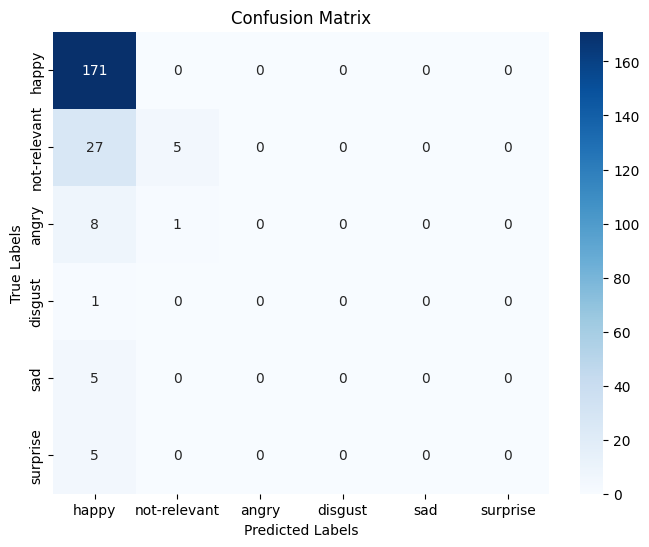

In [48]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

predicted_labels = np.argmax(predictions, axis=1)
true_labels = true_vals.flatten()

conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_dict.keys(), yticklabels=label_dict.keys())
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [45]:
accuracy_per_class(predictions, true_vals)

Class: happy
Accuracy: 171/171

Class: not-relevant
Accuracy: 5/32

Class: angry
Accuracy: 0/9

Class: disgust
Accuracy: 0/1

Class: sad
Accuracy: 0/5

Class: surprise
Accuracy: 0/5

